In [103]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [104]:
# Plot options
p = plt.rcParams
p["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM) # a bit less than half \textwidth
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.21
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.97
p['figure.subplot.bottom'] = 0.15
theoretical_marker = '_'
theoretical_markersize=208
theoretical_color='C1'
theoretical_lw = 1.5

In [105]:
# === Data import, low mean, 3ms dwell value
lowmean = np.loadtxt('../data/stat_lowmean3ms.TKA')

In [106]:
m = np.mean(lowmean)
total_counts = np.sum(lowmean)
total_samples = len(lowmean)
print(f"Mean of the low mean distribution measure set: {m:.2f}")

Mean of the low mean distribution measure set: 2.27


<BarContainer object of 11 artists>

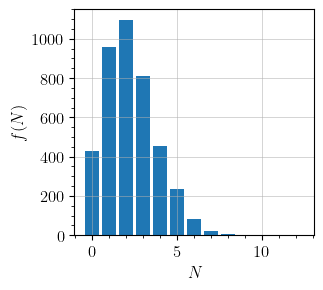

In [107]:
N, frequencies = np.unique_counts(lowmean)
plt.xlabel("$N$")
plt.ylabel("$f(N)$")
plt.bar(N, frequencies)

In [108]:
upper = 8
lower = 0
keep_idx = np.logical_and(N >= lower, N <= upper)
upper_idx = np.nonzero(keep_idx)[0][-1]
lower_idx = np.nonzero(keep_idx)[0][0]
add = True

merged_counts = N[keep_idx]
merged_frequencies = frequencies[keep_idx]
if add:
    merged_frequencies[-1] = np.sum(frequencies[upper_idx:])
    merged_frequencies[0] += np.sum(frequencies[:lower_idx])

poisson = sc.stats.poisson(m)
expected_probabilities = poisson.pmf(merged_counts)
# expected_probabilities[-1] = 1 - poisson.cdf(merged_counts[-1])  # = \sum_thresh^inf pmf
expected_frequencies = expected_probabilities * total_samples

test_statistic = np.sum((merged_frequencies - expected_frequencies)**2 / expected_frequencies)

dof =  len(merged_frequencies) - 1  # -1 bc we follow chi2, -1 bc of average
print(f"Degrees of freedom: {dof}")
chi2 = sc.stats.chi2(dof)

alpha = 0.05
alpha_statistic = chi2.ppf(1 - alpha)
print(f"Test statistic: {test_statistic}")
print(f"Critical value for alpha={alpha} is {alpha_statistic}")

pvalue = 1 - chi2.cdf(test_statistic)
print(f'p-value = {pvalue}')
print(f"This statistic has been {'NOT REJECTED' if pvalue > alpha else 'REJECTED'}")

Degrees of freedom: 8
Test statistic: 3.9534628566764645
Critical value for alpha=0.05 is 15.507313055865453
p-value = 0.861297591899411
This statistic has been NOT REJECTED


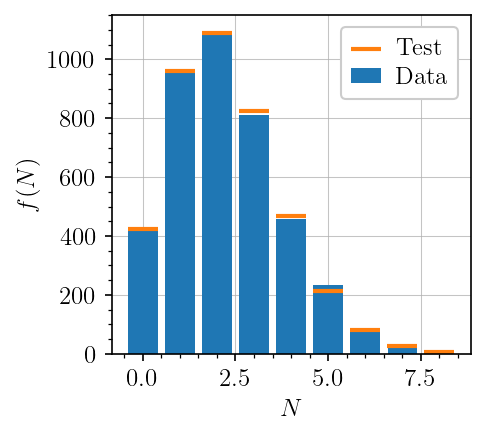

In [109]:
fig, ax = plt.subplots(1,1, dpi=150)
ax.set_axisbelow('True')
plt.xlabel("$N$")
plt.ylabel("$f(N)$")
plt.bar(merged_counts, merged_frequencies, 
        label='Data')
plt.scatter(merged_counts, expected_frequencies, 
            label='Test', marker=theoretical_marker, s=theoretical_markersize,
            c=theoretical_color, linewidths=2)
plt.legend()
plt.savefig("../figures/lowmean_poisson.pdf")

In [110]:
upper = 8
lower = 0
keep_idx = np.logical_and(N >= lower, N <= upper)
upper_idx = np.nonzero(keep_idx)[0][-1]
lower_idx = np.nonzero(keep_idx)[0][0]
add = True

merged_counts = N[keep_idx]
merged_frequencies = frequencies[keep_idx]
if add:
    merged_frequencies[-1] = np.sum(frequencies[upper_idx:])
    merged_frequencies[0] += np.sum(frequencies[:lower_idx])

gauss = sc.stats.norm(m, np.sqrt(m))
expected_probabilities = gauss.pdf(merged_counts)
if add:
    expected_probabilities[0] = gauss.cdf(merged_counts[0])
    expected_probabilities[-1] = 1 - gauss.cdf(merged_counts[-1])
expected_frequencies = expected_probabilities * np.sum(merged_frequencies)

test_statistic = np.sum((merged_frequencies - expected_frequencies)**2 / expected_frequencies)

dof =  len(merged_frequencies) - 1 - 1 # -1 bc we follow chi2, -1 bc of average, -1 bc of std
chi2 = sc.stats.chi2(dof)
print(f"Degrees of freedom: {dof}")

alpha = 0.05
alpha_statistic = chi2.ppf(1 - alpha)
print(f"Test statistic: {test_statistic}")
print(f"Critical value for alpha={alpha} is {alpha_statistic}")

pvalue = chi2.sf(test_statistic)
print(f'p-value = {pvalue}')
print(f"This statistic has been {'NOT REJECTED' if pvalue > alpha else 'REJECTED'}")

Degrees of freedom: 7
Test statistic: 561.1296793953074
Critical value for alpha=0.05 is 14.067140449340167
p-value = 5.683533602058586e-117
This statistic has been REJECTED


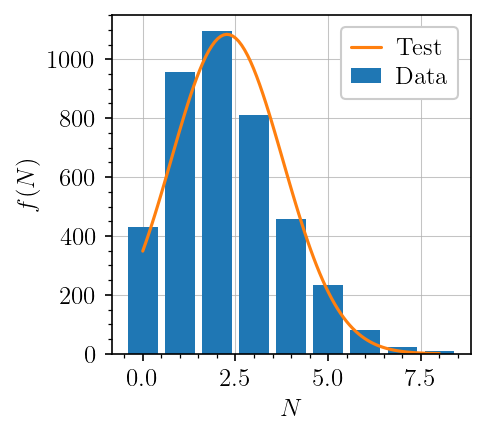

In [111]:
fig, ax = plt.subplots(1,1, dpi=150)
ax.set_axisbelow('True')
plt.xlabel("$N$")
plt.ylabel("$f(N)$")

plt.bar(merged_counts, merged_frequencies, 
        label='Data')
x = np.linspace(merged_counts[0], merged_counts[-1], 100, endpoint=True)
plt.plot(x, gauss.pdf(x) * total_samples, 
        label='Test', c=theoretical_color,
        ls='-', lw=theoretical_lw, solid_capstyle='round')
del x  # avoid polluting variables
plt.legend()
plt.savefig("../figures/lowmean_gaussian.pdf")

# HIGHMEAN

In [112]:
highmean = np.loadtxt('../data/stat_highmean300ms.TKA')

In [113]:
m = np.mean(highmean)
total_counts = np.sum(highmean)
total_samples = len(highmean)
print(f"Mean of the low mean distribution measure set: {m:.2f}")

Mean of the low mean distribution measure set: 228.10


In [114]:
N, frequencies = np.unique_counts(highmean)

In [115]:
upper = 275
lower = 1
keep_idx = np.logical_and(N >= lower, N <= upper)
upper_idx = np.nonzero(keep_idx)[0][-1]
lower_idx = np.nonzero(keep_idx)[0][0]
add = True

merged_counts = N[keep_idx]
merged_frequencies = frequencies[keep_idx]
if add:
    merged_frequencies[-1] = np.sum(frequencies[upper_idx:])
    merged_frequencies[0] += np.sum(frequencies[:lower_idx])

gauss = sc.stats.norm(m, np.sqrt(m))
expected_probabilities = gauss.pdf(merged_counts)
if add:
    expected_probabilities[0] = gauss.cdf(merged_counts[0])
    expected_probabilities[-1] = 1 - gauss.cdf(merged_counts[-1])
expected_frequencies = expected_probabilities * np.sum(merged_frequencies)

test_statistic = np.sum((merged_frequencies - expected_frequencies)**2 / expected_frequencies)

dof =  len(merged_frequencies) - 1 - 1 # -1 bc we follow chi2, -1 bc of average, -1 bc of std
chi2 = sc.stats.chi2(dof)
print(f"Degrees of freedom: {dof}")

alpha = 0.05
alpha_statistic = chi2.ppf(1 - alpha)
print(f"Test statistic: {test_statistic}")
print(f"Critical value for alpha={alpha} is {alpha_statistic}")

pvalue = 1 - chi2.cdf(test_statistic)
print(f'p-value = {pvalue}')
print(f"This statistic has been {'NOT REJECTED' if pvalue > alpha else 'REJECTED'}")

Degrees of freedom: 90
Test statistic: 97.97213213294152
Critical value for alpha=0.05 is 113.1452701425554
p-value = 0.265369755167695
This statistic has been NOT REJECTED


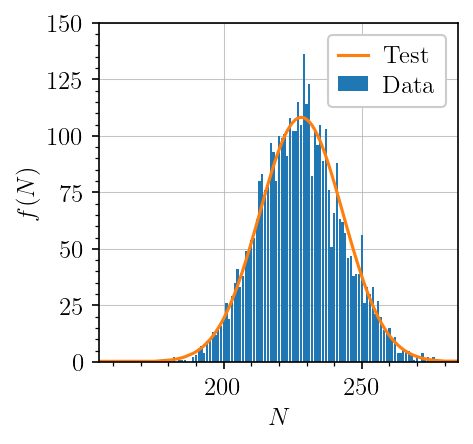

In [116]:
fig, ax = plt.subplots(1,1, dpi=150)
ax.set_axisbelow(True)
plt.xlabel("$N$")
plt.ylabel("$f(N)$")

plt.xlim(155, 285)
plt.ylim(0,150)

plt.bar(N, frequencies,
         label='Data')
# plt.plot(merged_counts, expected_frequencies,
#          label='Theoretical', c='C1')
# Show the correct pmf
plt.plot(N, gauss.pdf(N)*total_samples, 
         label='Test', c=theoretical_color,
         lw=theoretical_lw)
gauss_exp_f = expected_frequencies

plt.legend()
plt.savefig("../figures/highmean_gaussian.pdf")

In [117]:
upper = 275
lower = 1
keep_idx = np.logical_and(N >= lower, N <= upper)
upper_idx = np.nonzero(keep_idx)[0][-1]
lower_idx = np.nonzero(keep_idx)[0][0]
add = True

merged_counts = N[keep_idx]
merged_frequencies = frequencies[keep_idx]
if add:
    merged_frequencies[-1] = np.sum(frequencies[upper_idx:])
    merged_frequencies[0] += np.sum(frequencies[:lower_idx])

poisson = sc.stats.poisson(m)
expected_probabilities = poisson.pmf(merged_counts)
expected_probabilities[0] = poisson.cdf(merged_counts[0])
expected_probabilities[-1] = 1 - poisson.cdf(merged_counts[-1])  # = \sum_thresh^inf pmf
expected_frequencies = expected_probabilities * total_samples

test_statistic = np.sum((merged_frequencies - expected_frequencies)**2 / expected_frequencies)

dof =  len(merged_frequencies) - 1 # -1 bc we follow chi2, -1 bc of mu
chi2 = sc.stats.chi2(dof)
print(f"Degrees of freedom: {dof}")

alpha = 0.05
alpha_statistic = chi2.ppf(1 - alpha)
print(f"Test statistic: {test_statistic}")
print(f"Critical value for alpha={alpha} is {alpha_statistic}")

pvalue = 1 - chi2.cdf(test_statistic)
print(f'p-value = {pvalue}')
print(f"This statistic has been {'NOT REJECTED' if pvalue > alpha else 'REJECTED'}")

Degrees of freedom: 91
Test statistic: 94.62399963887775
Critical value for alpha=0.05 is 114.26786767719355
p-value = 0.3765994207515737
This statistic has been NOT REJECTED


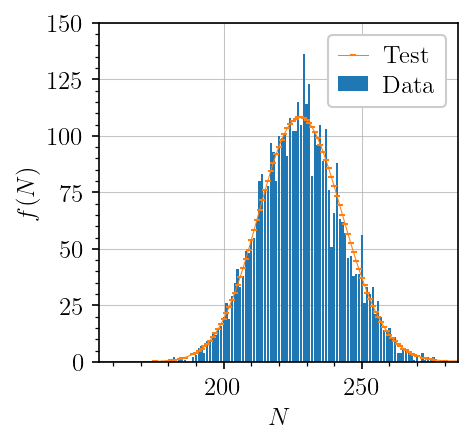

In [118]:
fig, ax = plt.subplots(1,1, dpi=150)
ax.set_axisbelow(True)
plt.xlabel("$N$")
plt.ylabel("$f(N)$")

plt.xlim(155, 285)
plt.ylim(0,150)
plt.bar(N, frequencies,
         label='Data')
# plt.plot(merged_counts, expected_frequencies,
#          label='Theoretical', c='C1')
# Show the correct pmf
# plt.scatter(N, poisson.pmf(N)*total_samples, 
#             label='Theoretical', c=theoretical_color,
#             marker=theoretical_marker, s=theoretical_markersize/155)
plt.plot(N, poisson.pmf(N)*total_samples,
         label='Test', ls='-', lw=0.5, c=theoretical_color,
         marker=theoretical_marker, ms=theoretical_markersize/80)
poiss_exp_freq = expected_frequencies
plt.legend()
plt.savefig("../figures/highmean_poisson.pdf")

[ 0.29424318  0.19091619  0.21698794  0.27355043  0.30323241  0.3331083
  0.41609496  0.43830781  0.45589447  0.46758216  0.47204897  0.467961
  0.45401638  0.42899496  0.39181277  0.34157929  0.27765563  0.19971108
  0.10777554  0.0022848  -0.11588392 -0.24538913 -0.38441708 -0.53069089
 -0.68149793 -0.83373631 -0.98398029 -1.12856349 -1.26367803 -1.38548675
 -1.49024473 -1.57442589 -1.6348497  -1.66880286 -1.67415063 -1.64943284
 -1.59393989 -1.50776488 -1.39182886 -1.24787731 -1.07844717 -0.88680508
 -0.67685865 -0.45304405 -0.22019386  0.01660945  0.25218893  0.48143115
  0.69944073  0.90168542  1.08412621  1.24332775  1.37654543  1.48178617
  1.5578418   1.60429443  1.62149497  1.61051672  1.57308696  1.51150044
  1.42851886  1.32726104  1.21108849  1.08349094  0.94797609  0.80796725
  0.6667122   0.52720541  0.39212557  0.2637891   0.14411991  0.03463486
 -0.06355613 -0.14973698 -0.22356115 -0.28501836 -0.33439461 -0.37222759
 -0.39925991 -0.41639173 -0.42463495 -0.42506999 -0.41

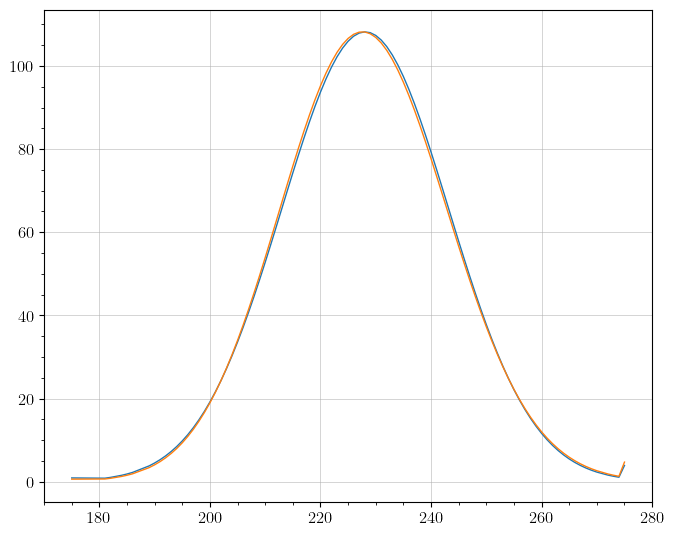

In [119]:
# Difference entre les deux
print(gauss_exp_f - poiss_exp_freq)
plt.figure(figsize=(8,6))
plt.plot(merged_counts, gauss_exp_f)
plt.plot(merged_counts, poiss_exp_freq)